# Discrete parameters

In this notebook, we discuss pyABC's abilities to deal with discrete parameters.

In its Sequential Monte Carlo algorithm, pyABC uses transition kernels $g_t$ that propose parameters for generation $t$ by slightly perturbing parameters that were accepted in generation $t-1$. Thus gradually sampling from a better and better approximation of the posterior, instead of the prior, we can reduce the acceptance threshold $\varepsilon$ while maintaining high acceptance rates. To account for no longer sampling from the prior $\pi$, we need to weight particles by $\pi(\theta) / g_t(\theta)$.

A formal requirement for any transition is that the prior is absolutely continuous with respect to it, i.e. $g_t\gg\pi$. This means that any value that has positive mass under the prior can still be sampled under the transition. Other than that, the transition can be arbitrary. Commonly, it should be close to the underlying posterior in order to achieve high acceptance rates. pyABC offers various transitions kernels that adjust automatically to the problem structure and thus deliver high-quality proposals. The default transition kernel `pyabc.MultivariateNormalTransition` as well as the `pyabc.LocalTransition` kernel both employ (localized/recscaled) multivariate normal kernels with adaptive covariance matrices. Therefore, they can learn about parameter scales and correlations.

However, they can only deal with continuous parameters.

Sometimes, parameters can only take discrete values and should thus also be modeled as such, e.g. via a discrete integer-valued prior. In that case, the above transitions cannot be applied, as they propose non-integer parameters. The, as far as implementation is concerned, most straightforward way to deal with this is to just round the suggested parameters to the next integer. However, to then obtain statistically correct weights, one would need to integrate the transition density over all values that are rounded to the same value. This can be computationally non-trivial and is also not implemented in pyABC, where one would instead just take the density value at the actually sampled parameters as an approximation, which is not strictly correct.

To efficiently and correctly deal with discrete parameters, pyABC also implements discrete transitions as classes derived from `pyabc.transition.DiscreteTransition`. Let us show an example:

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pyabc
%matplotlib inline
pyabc.settings.set_figure_params('pyabc')  # for beautified plots

We assume that we have a model with two parameters: A continuous variance parameter, and a mean parameter that can for some reason only take integer values from 0 to 6. To spice things up a little and get a non-trivial posterior distribution, the model randomly perturbs the mean by an offset of $\pm 2$.

In [2]:
n_data = 100

def model(p):
    return {'y': p['p_discrete'] + np.random.choice([-2, 0, 2], p=[0.2, 0.5, 0.3])
            + p['p_continuous'] * np.random.normal(size=n_data)}

distance = lambda x, x0: sum((x['y'] - x0['y'])**2)
p_true = {'p_discrete': 2, 'p_continuous': 0.5}
obs = model(p_true)

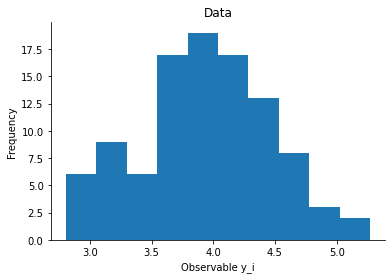

In [3]:
# plot the data
ax = plt.hist(obs['y'])
plt.xlabel("Observable y_i")
plt.ylabel("Frequency")
plt.title("Data")
plt.show()

Currently, there are two classes offered. First, there is the `pyabc.DiscreteRandomWalkTransition`, which is similarly also implemented in other tools. First it samples a parameter value from the weighted last generation and then performs a random walk of a fixed number of steps. While it can deal with unbounded discrete domains, it has the disadvantage, that it violates the absolute contiunuity condition and will thus not be further considered here. Let us know if you would like to discuss further details on this.

Here, we will in the following focus on the second implemented discrete transition, the `pyabc.DiscreteJumpTransition`, which requires a finite domain. It also first samples a parameter value from the weighted last generation, and ensures absolute positivity by with a positive probability `1 - p_stay` move to an arbitrary other value within the domain.

As we here also have another, continuous, parameter (for which we just use a `pyabc.MultivariateNormalTransition`), we use a `pyabc.AggregatedTransition` to combine both.

In [4]:
# domain of possible discrete values
discrete_domain = np.arange(7)

# priors
prior = pyabc.Distribution(
    p_discrete=pyabc.RV('rv_discrete', values=(discrete_domain, [1/7] * 7)),
    p_continuous=pyabc.RV('uniform', 0, 2))

# transition kernels
transition = pyabc.AggregatedTransition(mapping={
    'p_discrete': pyabc.DiscreteJumpTransition(domain=discrete_domain, p_stay=0.7),
    'p_continuous': pyabc.MultivariateNormalTransition()})

The transition kernels adjust to the problem structure via `fit()` functions that are called after each generation.

Let's run it:

In [5]:
abc = pyabc.ABCSMC(model, prior, distance, transitions=transition, population_size=1000)
abc.new(pyabc.create_sqlite_db_id(), obs)
history = abc.run(max_nr_populations=5)

INFO:Sampler:Parallelizing the sampling on 4 cores.
INFO:History:Start <ABCSMC(id=1, start_time=2021-02-03 13:27:04.995549)>
INFO:ABC:Calibration sample before t=0.
INFO:Epsilon:initial epsilon is 532.8985207147157
INFO:ABC:t: 0, eps: 532.8985207147157.
INFO:ABC:Acceptance rate: 1000 / 1943 = 5.1467e-01, ESS=1.0000e+03.
INFO:ABC:t: 1, eps: 246.51277130629907.
INFO:ABC:Acceptance rate: 1000 / 2957 = 3.3818e-01, ESS=9.3208e+02.
INFO:ABC:t: 2, eps: 139.40880503967205.
INFO:ABC:Acceptance rate: 1000 / 4961 = 2.0157e-01, ESS=9.2875e+02.
INFO:ABC:t: 3, eps: 97.37696808219137.
INFO:ABC:Acceptance rate: 1000 / 5822 = 1.7176e-01, ESS=8.5079e+02.
INFO:ABC:t: 4, eps: 43.89834541733582.
INFO:ABC:Acceptance rate: 1000 / 7134 = 1.4017e-01, ESS=9.0801e+02.
INFO:pyabc.util:Stopping: maximum number of generations.
INFO:History:Done <ABCSMC(id=1, duration=0:01:54.856937, end_time=2021-02-03 13:28:59.852486>


We see in the result that we perfectly reproduce the 3 likely mean parameters with their respective probabilities. Over time, the posterior approximation get gradually more accurate.

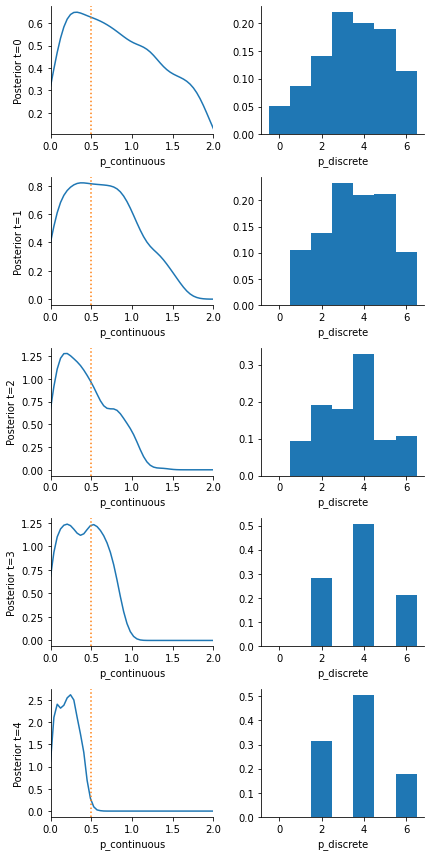

In [6]:
# some visualizations
fig, axes = plt.subplots(history.max_t+1, 2, figsize=(6, 12))
for t in range(history.max_t+1):
    pyabc.visualization.plot_kde_1d_highlevel(
        history, 'p_continuous', t=t, refval=p_true, xmin=0, xmax=2,
        ax=axes[t, 0])
    pyabc.visualization.plot_histogram_1d(
        history, 'p_discrete', t=t, bins=np.arange(8), align='left',
        ax=axes[t, 1])
    axes[t, 0].set_ylabel(f"Posterior t={t}")
fig.tight_layout()